# Sickle Cell Anemia Analysis and Classification

## Introduction

This Jupyter notebook analyzes a sickle cell anemia dataset, performs exploratory data analysis, and builds a classification model to predict a patient's sickle cell status. The notebook begins by importing the necessary libraries for data analysis and visualization. Then, it loads the sickle cell anemia dataset into a pandas DataFrame. Exploratory data analysis is performed to gain insights into the dataset, including displaying the first few rows, checking for missing values, and visualizing the distribution and correlation of features. The dataset is then preprocessed by handling missing values, encoding categorical variables, and scaling numeric features. Data visualization techniques are used to better understand the characteristics of the dataset. Feature selection is conducted to select the most relevant features for building the classification model. The dataset is split into training and testing sets for model evaluation. A classification model using logistic regression is built, trained, and evaluated. Model tuning is performed to improve its performance by tuning the hyperparameters. Finally, the trained classification model is used to predict the sickle cell status for new patients.

### Dataset Info
- NO: Patient ID
- LAB_TEST: The attribute name of the blood test which is either one of the following (Heamoglobin, MCH, MCHC, MCV)
- RESULT: Lap test result
- REFERENCE_INTERVAL: The expected value for blood with normal condition
- GENDER: Female/Male
- IDENTIFICATION: Whether or not a patient has anemia

## Loading the Dataset

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [31]:
# Load the sickle cell anemia dataset into a pandas DataFrame
df = pd.read_csv('Anemia.csv')

## Exploratory Data Analysis

In [32]:
# Display the first few rows of the dataset
df.head()

,NO,LAB_TEST,RESULT,REFERENCE_INTERVAL,GENDER,IDENTIFICATION
0,1,Hemoglobin,14.9,13.5 - 17.5,Male,Not Anemia
1,1,MCH,22.7,27.0 - 31.0,Male,Not Anemia
2,1,MCHC,29.1,32.0 - 36.0,Male,Not Anemia
3,1,MCV,83.7,82.0 - 92.0,Male,Not Anemia
4,2,Hemoglobin,15.9,12.0 - 16.0,Female,Not Anemia


In [33]:
# Get the info of the datset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5684 entries, 0 to 5683
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NO                  5684 non-null   int64  
 1   LAB_TEST            5684 non-null   object 
 2   RESULT              5684 non-null   float64
 3   REFERENCE_INTERVAL  5684 non-null   object 
 4   GENDER              5684 non-null   object 
 5   IDENTIFICATION      5684 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 266.6+ KB


In [34]:
# Check for missing values in the dataset
df.isnull().sum()

NO                    0
LAB_TEST              0
RESULT                0
REFERENCE_INTERVAL    0
GENDER                0
IDENTIFICATION        0
dtype: int64

As seen above, there are no missing values

In [35]:
# Get the summary statistics of the dataset
df.describe()

,NO,RESULT
count,5684.000000,5684.000000
mean,711.000000,38.023346
std,410.243354,28.574037
min,1.000000,6.600000
25%,356.000000,16.700000
50%,711.000000,28.300000
75%,1066.000000,41.725000
max,1421.000000,101.600000


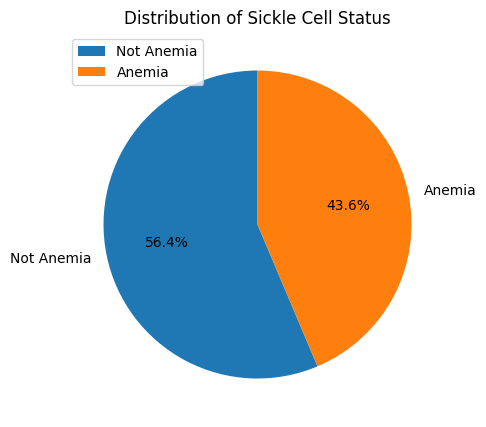

In [36]:
# Calculate the count and percentage for each category
sickle_cell_counts = df['IDENTIFICATION'].value_counts()
sickle_cell_percentages = df['IDENTIFICATION'].value_counts(normalize=True) * 100

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(sickle_cell_counts, labels=sickle_cell_counts.index, autopct='%1.1f%%', startangle=90)

# Add percentages to the pie chart
plt.gca().set_aspect('equal')
plt.legend(sickle_cell_percentages.index, loc='best')
plt.title('Distribution of Sickle Cell Status')
plt.savefig("pie.jpg")

### What gender was likely to have anemia

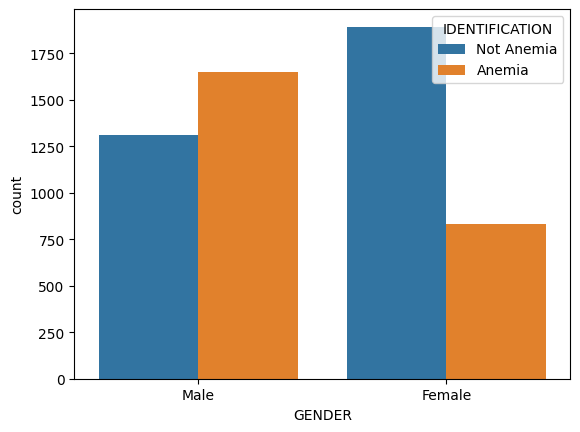

In [37]:
sns.countplot(data=df, x="GENDER", hue="IDENTIFICATION");
plt.savefig("gen.jpg")

In [38]:
# Splitting the REFERENCE_INTERVAL column into ref_min and ref_max columns
data = df.copy()
data[['min_ref', 'max_ref']] = data['REFERENCE_INTERVAL'].str.split('-', expand=True)

# Converting ref_min and ref_max columns to numeric
data[['min_ref', 'max_ref']] = data[['min_ref', 'max_ref']].apply(pd.to_numeric)

# Creating new columns based on conditions
# data['in_ref_val'] = (data['RESULT'].between(data['min_ref'], data['max_ref'], inclusive=True)).astype(int)
data['over_ref_val'] = (data['RESULT'] > data['max_ref']).astype(int)
data['under_ref_val'] = (data['RESULT'] < data['min_ref']).astype(int)
data['perc_ref'] = (data['RESULT'] - data['min_ref']) / (data['max_ref'] - data['min_ref'])

data.head()

,NO,LAB_TEST,RESULT,REFERENCE_INTERVAL,GENDER,IDENTIFICATION,min_ref,max_ref,over_ref_val,under_ref_val,perc_ref
0,1,Hemoglobin,14.9,13.5 - 17.5,Male,Not Anemia,13.5,17.5,0,0,0.350
1,1,MCH,22.7,27.0 - 31.0,Male,Not Anemia,27.0,31.0,0,1,-1.075
2,1,MCHC,29.1,32.0 - 36.0,Male,Not Anemia,32.0,36.0,0,1,-0.725
3,1,MCV,83.7,82.0 - 92.0,Male,Not Anemia,82.0,92.0,0,0,0.170
4,2,Hemoglobin,15.9,12.0 - 16.0,Female,Not Anemia,12.0,16.0,0,0,0.975


### What Lab test typically led to the outcome of Anemia when lower than the reference interval?

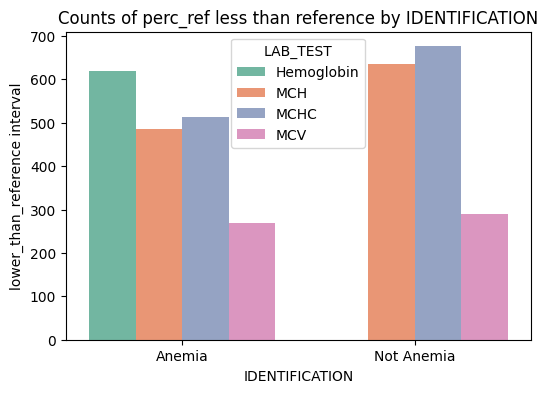

In [39]:
# Filter out rows where LAB_TEST is not empty
filtered_data = data[data['LAB_TEST'] != '']

# Group by IDENTIFICATION and LAB_TEST, and calculate the desired summary statistics
grouped_data = filtered_data.groupby(['IDENTIFICATION', 'LAB_TEST']).agg(median_perc_ref=('perc_ref', 'median'),
                                                                         mean_perc_ref=('perc_ref', 'mean'),
                                                                         lower_than_ref=('perc_ref', lambda x: sum(x < 0)),
                                                                         higher_than_ref=('perc_ref', lambda x: sum(x > 1)))

# Reset the index to convert the grouped DataFrame back to a regular DataFrame
grouped_data = grouped_data.reset_index()

# Plot the data using seaborn and matplotlib
plt.figure(figsize=(6, 4))
sns.barplot(data=grouped_data, x='IDENTIFICATION', y='lower_than_ref', hue='LAB_TEST', palette='Set2')
plt.xlabel('IDENTIFICATION')
plt.ylabel('lower_than_reference interval')
plt.title('Counts of perc_ref less than reference by IDENTIFICATION');
plt.savefig("test.jpg")

## Data Preprocessing

In [40]:
def preprocess_data(df):
    """
    Function to preprocess data
    """
    
    #Drop un-needeed columns
    df.drop(["NO", "REFERENCE_INTERVAL"], axis=1, inplace=True)
    
    # Encoding Categorical Variables
    le = LabelEncoder()
    cat_cols = df.select_dtypes("object").columns
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])
    
    return df

processed_df = preprocess_data(data)
processed_df.head()

,LAB_TEST,RESULT,GENDER,IDENTIFICATION,min_ref,max_ref,over_ref_val,under_ref_val,perc_ref
0,0,14.9,1,1,13.5,17.5,0,0,0.350
1,1,22.7,1,1,27.0,31.0,0,1,-1.075
2,2,29.1,1,1,32.0,36.0,0,1,-0.725
3,3,83.7,1,1,82.0,92.0,0,0,0.170
4,0,15.9,0,1,12.0,16.0,0,0,0.975


## Splitting the Dataset

In [41]:
# Separate the features and target variable
X = processed_df.drop('IDENTIFICATION', axis=1)
y = processed_df['IDENTIFICATION']

In [42]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Print the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (4547, 8), (4547,)
Testing set shape: (1137, 8), (1137,)


### Feature Scaling

In [44]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(X_train)

# Scale the cross validation set using the mean and standard deviation of the training set
X_test_scaled = scaler_linear.transform(X_test)

## Building the Classification Model

In [58]:
def evaluate_performance(model, x_test, y_test):
    """
    Evaluates the performance of a classification model by calculating and displaying the confusion matrix and classification report.

    Parameters:
    - model: The trained classification model.
    - x_test: The feature values of the test set.
    - y_test: The corresponding true labels of the test set.

    Returns:
    None

    Prints:
    - The classification report, which includes metrics such as precision, recall, F1-score, and support for each class.
    - The confusion matrix, which shows the number of true positives, true negatives, false positives, and false negatives for each class.
    """

    # Predict the labels for the test set
    y_pred = model.predict(x_test)

    # Calculate the confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    cr = classification_report(y_test, y_pred)

    # Print the confusion matrix and classification report
    print("Classification Report:\n", cr)
    print("Confusion Matix")
    print(cm)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Anemia", "Not Anemia"])
    disp.plot();

In [52]:
# Initialize the logistic regression model
LR = LogisticRegression()
# Fit the model on the training data
LR.fit(X_train_scaled, y_train)


LogisticRegression()

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.63      0.65       505
           1       0.72      0.75      0.74       632

    accuracy                           0.70      1137
   macro avg       0.70      0.69      0.69      1137
weighted avg       0.70      0.70      0.70      1137



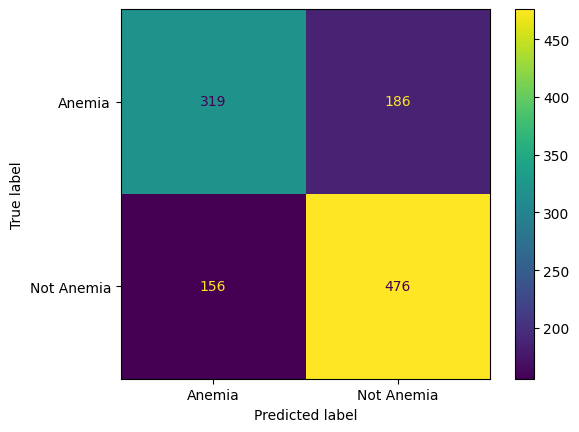

In [53]:
evaluate_performance(LR, X_test_scaled, y_test)

### RandomForestClassifier

In [56]:
RF_classifier = RandomForestClassifier(max_depth=45)
RF_classifier.fit(X_train_scaled, y_train);

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77       505
           1       0.81      0.83      0.82       632

    accuracy                           0.80      1137
   macro avg       0.80      0.79      0.79      1137
weighted avg       0.80      0.80      0.80      1137

Confusion Matix
[[383 122]
 [108 524]]


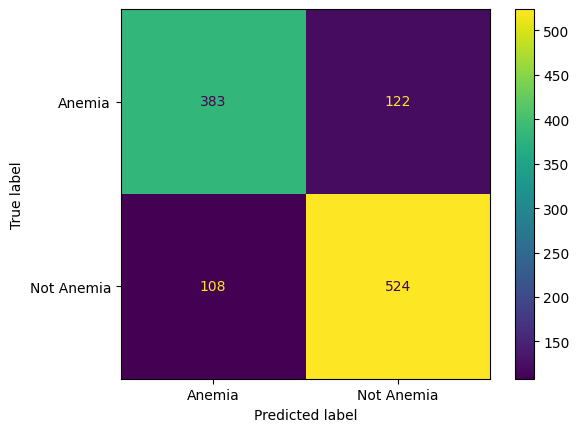

In [59]:
evaluate_performance(RF_classifier, X_test_scaled, y_test)

The random forest does a better job at classifying the dataset with an accuracy of 80%